# Continuous Control

---

In this notebook, we will train and watch a double-jointed arm DDPG Agent move to target locations and maintain its position at the target location for as many time steps as possible.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name='/Users/NhatAnh/Documents/ML/DRL/DeepRL-Continuous-Control/Reacher.app')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726624e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


### 3. Train DDPG


In [5]:
import sys
import os
import torch
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname(__name__), '..')))

from ddpg.ddpg_agent import MADDPGAgent

In [6]:
# Score that the agent needs to achieve
BENCHMARK_SCORE = 30.0

In [7]:
# Create an Agent
agent = MADDPGAgent(state_size, action_size, num_agents, random_seed=0)

In [8]:
def train_ddpg(n_episodes=2000, max_t=1000, eps_start=1.0, eps_decay=1e-5, eps_end=0.1):
    """Train Agent with DDPG
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): linear factor (per episode) for decreasing epsilon
    """
    scores_window = deque(maxlen=100)
    scores = []
    
    eps = eps_start
    for i_episode in range(1, n_episodes + 1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        
        agent.reset()
        episode_scores = np.zeros(num_agents)
        
        for t in range(max_t):
            actions = agent.act(states, eps)
            env_info = env.step(actions)[brain_name]
            
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            
            for i in range(num_agents):
                agent.step(states[i], actions[i], rewards[i], next_states[i], dones[i], t)
            
            states = next_states
            episode_scores += rewards
            
            if np.any(dones):
                break
                
            eps = max(eps_end, eps-eps_decay)
            
        score = np.mean(episode_scores)
        
        scores_window.append(score)
        scores.append(score)
        
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(i_episode, np.mean(scores_window), score), end="")

        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            
        torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
        torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
        
        
        if np.mean(scores_window) >= BENCHMARK_SCORE:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            break
            
    return scores

In [9]:
def plot(scores):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(1, len(scores)+1), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

In [10]:
# Load checkpoint
if os.path.isfile('checkpoint_actor.pth') and os.path.isfile('checkpoint_critic.pth'):
    agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
    agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))
    print("Weight loaded.")

Weight loaded.


Episode 91	Average Score: 30.06	Score: 38.97
Environment solved in 91 episodes!	Average Score: 30.06


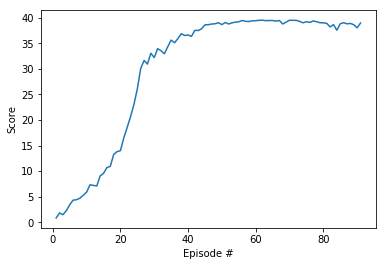

In [11]:
scores = train_ddpg()
plot(scores)